# Tutorial 6: Mixed Precision Quantization Search with Mase and Optuna

In this tutorial, we'll see how Mase can be integrated with Optuna, the popular hyperparameter optimization framework, to search for a Bert model optimized for sequence classification on the IMDb dataset. We'll take the Optuna-generated model and import it into Mase, then run the CompressionPipeline to prepare the model for edge deployment by quantizing and pruning its weights.

As we'll see, running Architecture Search with Mase/Optuna involves the following steps.

1. **Define the search space**: this is a dictionary containing the range of values for each parameter at each layer in the model.

2. **Write the model constructor**: this is a function which uses Optuna utilities to sample a model from the search space, and constructs the model using transformers from_config class method.

3. **Write the objective function**: this function calls on the model constructor defined in Step 2 and defines the training/evaluation setup for each search iteration.

4. **Go!** Choose an Optuna sampler, create a study and launch the search.

In [2]:
checkpoint = "prajjwal1/bert-tiny"
tokenizer_checkpoint = "bert-base-uncased"
dataset_name = "imdb"

## Importing the model

If you are starting from scratch, you can load the Bert checkpoint directly from HuggingFace.

In [3]:
from transformers import AutoModel

model = AutoModel.from_pretrained(checkpoint)

/usr/local/lib/python3.11/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/local/lib/python3.11/dist-packages/torch/cuda/__init__.py:61: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]
/usr/local/lib/python3.11/dist-packages/transformers/utils/hub.py:105: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


If you have previously ran the tutorial on Neural Architecture Search (NAS), run the following cell to import the best model obtained from the search process.

In [4]:
from pathlib import Path
import dill

lab2_out_dir = Path("/workspace/labs/lab2/outputs")
lab3_out_dir = Path("/workspace/labs/lab3/outputs")

with open(f"{lab2_out_dir}/tutorial_5_best_model.pkl", "rb") as f:
    base_model = dill.load(f)

First, fetch the dataset using the `get_tokenized_dataset` utility.

In [5]:
from chop.tools import get_tokenized_dataset

dataset, tokenizer = get_tokenized_dataset(
    dataset=dataset_name,
    checkpoint=tokenizer_checkpoint,
    return_tokenizer=True,
)

INFO     Tokenizing dataset imdb with AutoTokenizer for bert-base-uncased.


## 1. Defining the Search Space

We'll start by defining a search space, i.e. enumerating the possible combinations of hyperparameters that Optuna can choose during search. We'll explore the following range of values for the model's hidden size, intermediate size, number of layers and number of heads.

In [6]:
import torch
from chop.nn.quantized.modules.linear import (
    LinearInteger,
    LinearMinifloatDenorm,
    LinearMinifloatIEEE,
    LinearLog,
    LinearBlockFP,
    LinearBlockMinifloat,
    LinearBlockLog,
    LinearBinary,
    LinearBinaryScaling,
    LinearBinaryResidualSign,
)

search_space = {
    "linear_layer_choices": [
        torch.nn.Linear,
        LinearInteger,
    ],
}

## 2. Writing a Model Constructor

We define the following function, which will get called in each iteration of the search process. The function is passed the `trial` argument, which is an Optuna object that comes with many functionalities - see the [Trial documentation](https://optuna.readthedocs.io/en/stable/reference/trial.html) for more details. Here, we use the `trial.suggest_categorical` function, which triggers the chosen sampler to choose a layer type. The suggested integer is the index into the search space for each parameter, which we defined in the previous cell.

In [7]:
from chop.tools.utils import deepsetattr
from copy import deepcopy


def construct_model(trial):

    # Fetch the model
    trial_model = deepcopy(base_model)

    # Quantize layers according to optuna suggestions
    for name, layer in trial_model.named_modules():
        if isinstance(layer, torch.nn.Linear):
            new_layer_cls = trial.suggest_categorical(
                f"{name}_type",
                search_space["linear_layer_choices"],
            )

            if new_layer_cls == torch.nn.Linear:
                continue

            kwargs = {
                "in_features": layer.in_features,
                "out_features": layer.out_features,
            }

            # If the chosen layer is integer, define the low precision config
            if new_layer_cls == LinearInteger:
                kwargs["config"] = {
                    "data_in_width": 8,
                    "data_in_frac_width": 4,
                    "weight_width": 8,
                    "weight_frac_width": 4,
                    "bias_width": 8,
                    "bias_frac_width": 4,
                }
            # elif... (other precisions)

            # Create the new layer (copy the weights)
            new_layer = new_layer_cls(**kwargs)
            new_layer.weight.data = layer.weight.data

            # Replace the layer in the model
            deepsetattr(trial_model, name, new_layer)

    return trial_model

## 3. Defining the Objective Function

Next, we define the objective function for the search, which gets called on each trial. In each trial, we create a new model instace with chosen hyperparameters according to the defined sampler. We then use the `get_trainer` utility in Mase to run a training loop on the IMDb dataset for a number of epochs. Finally, we use `evaluate` to report back the classification accuracy on the test split.

In [8]:
from chop.tools import get_trainer
import random


def objective(trial):

    # Define the model
    model = construct_model(trial)

    trainer = get_trainer(
        model=model,
        tokenized_dataset=dataset,
        tokenizer=tokenizer,
        evaluate_metric="accuracy",
        num_train_epochs=1,
    )

    trainer.train()
    eval_results = trainer.evaluate()

    trial.set_user_attr("model", model)

    return eval_results["eval_accuracy"]

## 4. Launching the Search

Optuna provides a number of samplers, for example:

* **GridSampler**: iterates through every possible combination of hyperparameters in the search space
* **RandomSampler**: chooses a random combination of hyperparameters in each iteration
* **TPESampler**: uses Tree-structured Parzen Estimator algorithm to choose hyperparameter values.

You can define the chosen sampler by simply importing from `optuna.samplers` as below.

In [9]:
from optuna.samplers import GridSampler, RandomSampler, TPESampler

sampler = RandomSampler()

With all the pieces in place, we can launch the search as follows. The number of trials is set to 1 so you can go get a coffee for 10 minutes, then proceed with the tutorial. However, this will essentially be a random model - for better results, set this to 100 and leave it running overnight!

In [10]:
import optuna

study = optuna.create_study(
    direction="maximize",
    study_name="bert-tiny-nas-study",
    sampler=sampler,
)

study.optimize(
    objective,
    n_trials=1,
    timeout=60 * 60 * 24,
)

[I 2026-02-03 01:59:46,061] A new study created in memory with name: bert-tiny-nas-study
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:502: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.nn.modules.linear.Linear'> which is of type type.
  optuna_warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:502: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'chop.nn.quantized.modules.linear.LinearInteger'> which is of type type.
  optuna_warn(message)
/workspace/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.304900
1000,0.306100
1500,0.306300
2000,0.325600
2500,0.307800
3000,0.360600


[I 2026-02-03 02:02:22,909] Trial 0 finished with value: 0.87464 and parameters: {'bert.encoder.layer.0.attention.self.query_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.intermediate.dense_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.1.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.

/usr/local/lib/python3.11/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/local/lib/python3.11/dist-packages/torch/cuda/__init__.py:61: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]
/usr/local/lib/python3.11/dist-packages/transformers/utils/hub.py:105: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
INFO     Tokenizing dataset imdb with AutoTokenizer for bert-base-uncased.


=== Task 1: Integer per-layer width/frac search ===


[I 2026-02-05 01:30:55,243] Using an existing study with name 'tutorial6_integer_layerwise_widthfrac' instead of creating a new one.


[skip] tutorial6_integer_layerwise_widthfrac: already has 24 COMPLETE trials


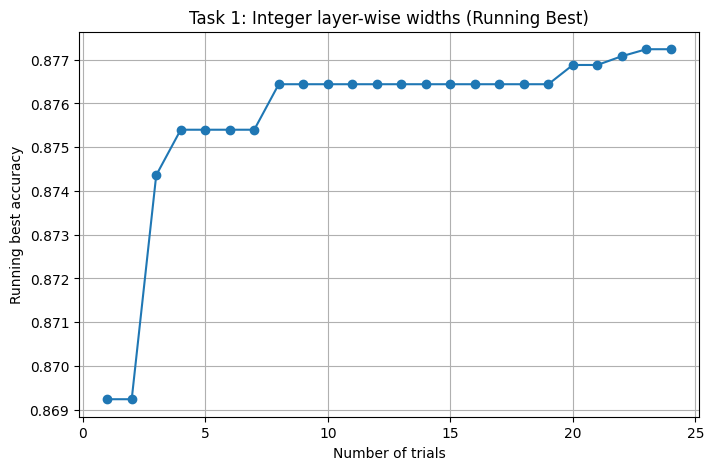

[I 2026-02-05 01:30:55,449] Using an existing study with name 'tutorial6_prec_integer' instead of creating a new one.


Task 1 best: 0.87724
Saved: /workspace/labs/lab3/outputs/tutorial6_task1_integer_layerwise_running_best.png

=== Task 2: Compare precision families ===

-- Running study for precision: integer
[skip] tutorial6_prec_integer: already has 24 COMPLETE trials
Best for integer: 0.8771
Snapshot: /workspace/labs/lab3/outputs/task2_integer_snapshot.json

-- Running study for precision: minifloat_ieee


[I 2026-02-05 01:30:55,507] Using an existing study with name 'tutorial6_prec_minifloat_ieee' instead of creating a new one.
[I 2026-02-05 01:30:55,570] Using an existing study with name 'tutorial6_prec_minifloat_denorm' instead of creating a new one.
[I 2026-02-05 01:30:55,607] Using an existing study with name 'tutorial6_prec_log' instead of creating a new one.


[skip] tutorial6_prec_minifloat_ieee: already has 24 COMPLETE trials
Best for minifloat_ieee: 0.8773
Snapshot: /workspace/labs/lab3/outputs/task2_minifloat_ieee_snapshot.json

-- Running study for precision: minifloat_denorm
[skip] tutorial6_prec_minifloat_denorm: already has 24 COMPLETE trials
Best for minifloat_denorm: 0.8771
Snapshot: /workspace/labs/lab3/outputs/task2_minifloat_denorm_snapshot.json

-- Running study for precision: log
[skip] tutorial6_prec_log: already has 24 COMPLETE trials
Best for log: 0.8765
Snapshot: /workspace/labs/lab3/outputs/task2_log_snapshot.json

-- Running study for precision: blockfp


[I 2026-02-05 01:30:55,643] Using an existing study with name 'tutorial6_prec_blockfp' instead of creating a new one.
[I 2026-02-05 01:30:55,683] Using an existing study with name 'tutorial6_prec_blockminifloat' instead of creating a new one.
[I 2026-02-05 01:30:55,726] Using an existing study with name 'tutorial6_prec_blocklog' instead of creating a new one.


[skip] tutorial6_prec_blockfp: already has 24 COMPLETE trials
Best for blockfp: 0.8762
Snapshot: /workspace/labs/lab3/outputs/task2_blockfp_snapshot.json

-- Running study for precision: blockminifloat
[skip] tutorial6_prec_blockminifloat: already has 12 COMPLETE trials
Best for blockminifloat: 0.8434
Snapshot: /workspace/labs/lab3/outputs/task2_blockminifloat_snapshot.json

-- Running study for precision: blocklog
[run]  tutorial6_prec_blocklog: running 12 more trial(s) to reach 12 COMPLETE


/workspace/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.310500
1000,0.303100
1500,0.298000
2000,0.318100
2500,0.307000
3000,0.350100


[I 2026-02-05 01:41:35,480] Trial 12 finished with value: 0.87528 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'blocklog', 'bert.encoder.layer.0.attention.self.key_type': 'fp', 'bert.encoder.layer.0.attention.self.value_type': 'blocklog', 'bert.encoder.layer.0.attention.output.dense_type': 'blocklog', 'bert.encoder.layer.0.intermediate.dense_type': 'fp', 'bert.encoder.layer.0.output.dense_type': 'fp', 'bert.encoder.layer.1.attention.self.query_type': 'blocklog', 'bert.encoder.layer.1.attention.self.key_type': 'blocklog', 'bert.encoder.layer.1.attention.output.dense_type': 'blocklog', 'bert.encoder.layer.1.intermediate.dense_type': 'blocklog', 'bert.encoder.layer.1.output.dense_type': 'fp', 'classifier_type': 'blocklog'}. Best is trial 12 with value: 0.87528.
/workspace/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.303700
1000,0.318800
1500,0.303400
2000,0.322200
2500,0.312100
3000,0.356300


[I 2026-02-05 01:55:10,881] Trial 13 finished with value: 0.87588 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'blocklog', 'bert.encoder.layer.0.attention.self.key_type': 'blocklog', 'bert.encoder.layer.0.attention.self.value_type': 'fp', 'bert.encoder.layer.0.attention.output.dense_type': 'blocklog', 'bert.encoder.layer.0.intermediate.dense_type': 'blocklog', 'bert.encoder.layer.0.output.dense_type': 'blocklog', 'bert.encoder.layer.1.attention.self.query_type': 'blocklog', 'bert.encoder.layer.1.attention.self.key_type': 'fp', 'bert.encoder.layer.1.attention.output.dense_type': 'blocklog', 'bert.encoder.layer.1.intermediate.dense_type': 'fp', 'bert.encoder.layer.1.output.dense_type': 'blocklog', 'classifier_type': 'fp'}. Best is trial 13 with value: 0.87588.
/workspace/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.307300
1000,0.296700
1500,0.309600
2000,0.323000
2500,0.310500
3000,0.357700


[I 2026-02-05 01:59:53,642] Trial 14 finished with value: 0.87648 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'blocklog', 'bert.encoder.layer.0.attention.self.key_type': 'fp', 'bert.encoder.layer.0.attention.self.value_type': 'fp', 'bert.encoder.layer.0.attention.output.dense_type': 'fp', 'bert.encoder.layer.0.intermediate.dense_type': 'fp', 'bert.encoder.layer.0.output.dense_type': 'fp', 'bert.encoder.layer.1.attention.self.query_type': 'fp', 'bert.encoder.layer.1.attention.self.key_type': 'fp', 'bert.encoder.layer.1.attention.output.dense_type': 'blocklog', 'bert.encoder.layer.1.intermediate.dense_type': 'fp', 'bert.encoder.layer.1.output.dense_type': 'fp', 'classifier_type': 'fp'}. Best is trial 14 with value: 0.87648.
/workspace/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.312100
1000,0.301800
1500,0.312700
2000,0.326000
2500,0.307300
3000,0.356000


[I 2026-02-05 02:10:02,674] Trial 15 finished with value: 0.876 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'fp', 'bert.encoder.layer.0.attention.self.key_type': 'fp', 'bert.encoder.layer.0.attention.self.value_type': 'fp', 'bert.encoder.layer.0.attention.output.dense_type': 'fp', 'bert.encoder.layer.0.intermediate.dense_type': 'blocklog', 'bert.encoder.layer.0.output.dense_type': 'blocklog', 'bert.encoder.layer.1.attention.self.query_type': 'fp', 'bert.encoder.layer.1.attention.self.key_type': 'fp', 'bert.encoder.layer.1.attention.output.dense_type': 'blocklog', 'bert.encoder.layer.1.intermediate.dense_type': 'blocklog', 'bert.encoder.layer.1.output.dense_type': 'blocklog', 'classifier_type': 'fp'}. Best is trial 14 with value: 0.87648.
/workspace/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.311500
1000,0.299300
1500,0.309400
2000,0.328700
2500,0.312900
3000,0.358600


[I 2026-02-05 02:17:12,157] Trial 16 finished with value: 0.87468 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'fp', 'bert.encoder.layer.0.attention.self.key_type': 'fp', 'bert.encoder.layer.0.attention.self.value_type': 'fp', 'bert.encoder.layer.0.attention.output.dense_type': 'blocklog', 'bert.encoder.layer.0.intermediate.dense_type': 'blocklog', 'bert.encoder.layer.0.output.dense_type': 'fp', 'bert.encoder.layer.1.attention.self.query_type': 'blocklog', 'bert.encoder.layer.1.attention.self.key_type': 'blocklog', 'bert.encoder.layer.1.attention.output.dense_type': 'fp', 'bert.encoder.layer.1.intermediate.dense_type': 'fp', 'bert.encoder.layer.1.output.dense_type': 'fp', 'classifier_type': 'fp'}. Best is trial 14 with value: 0.87648.
/workspace/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.313100
1000,0.298600
1500,0.303700
2000,0.323800
2500,0.300400
3000,0.353900


[I 2026-02-05 02:25:32,472] Trial 17 finished with value: 0.87552 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'fp', 'bert.encoder.layer.0.attention.self.key_type': 'fp', 'bert.encoder.layer.0.attention.self.value_type': 'blocklog', 'bert.encoder.layer.0.attention.output.dense_type': 'blocklog', 'bert.encoder.layer.0.intermediate.dense_type': 'fp', 'bert.encoder.layer.0.output.dense_type': 'fp', 'bert.encoder.layer.1.attention.self.query_type': 'blocklog', 'bert.encoder.layer.1.attention.self.key_type': 'blocklog', 'bert.encoder.layer.1.attention.output.dense_type': 'blocklog', 'bert.encoder.layer.1.intermediate.dense_type': 'fp', 'bert.encoder.layer.1.output.dense_type': 'fp', 'classifier_type': 'blocklog'}. Best is trial 14 with value: 0.87648.
/workspace/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.305500
1000,0.292100
1500,0.307000
2000,0.319400
2500,0.302100
3000,0.350800


[I 2026-02-05 02:36:12,650] Trial 18 finished with value: 0.8752 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'fp', 'bert.encoder.layer.0.attention.self.key_type': 'blocklog', 'bert.encoder.layer.0.attention.self.value_type': 'blocklog', 'bert.encoder.layer.0.attention.output.dense_type': 'blocklog', 'bert.encoder.layer.0.intermediate.dense_type': 'blocklog', 'bert.encoder.layer.0.output.dense_type': 'blocklog', 'bert.encoder.layer.1.attention.self.query_type': 'fp', 'bert.encoder.layer.1.attention.self.key_type': 'fp', 'bert.encoder.layer.1.attention.output.dense_type': 'fp', 'bert.encoder.layer.1.intermediate.dense_type': 'blocklog', 'bert.encoder.layer.1.output.dense_type': 'fp', 'classifier_type': 'blocklog'}. Best is trial 14 with value: 0.87648.
/workspace/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.314700
1000,0.303200
1500,0.307900
2000,0.330500
2500,0.308000
3000,0.359800


[I 2026-02-05 02:42:30,319] Trial 19 finished with value: 0.87564 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'fp', 'bert.encoder.layer.0.attention.self.key_type': 'fp', 'bert.encoder.layer.0.attention.self.value_type': 'fp', 'bert.encoder.layer.0.attention.output.dense_type': 'fp', 'bert.encoder.layer.0.intermediate.dense_type': 'blocklog', 'bert.encoder.layer.0.output.dense_type': 'fp', 'bert.encoder.layer.1.attention.self.query_type': 'blocklog', 'bert.encoder.layer.1.attention.self.key_type': 'fp', 'bert.encoder.layer.1.attention.output.dense_type': 'fp', 'bert.encoder.layer.1.intermediate.dense_type': 'blocklog', 'bert.encoder.layer.1.output.dense_type': 'fp', 'classifier_type': 'fp'}. Best is trial 14 with value: 0.87648.
/workspace/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.312900
1000,0.298600
1500,0.302700
2000,0.321400
2500,0.301800
3000,0.356200


[I 2026-02-05 02:52:25,939] Trial 20 finished with value: 0.87356 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'blocklog', 'bert.encoder.layer.0.attention.self.key_type': 'fp', 'bert.encoder.layer.0.attention.self.value_type': 'blocklog', 'bert.encoder.layer.0.attention.output.dense_type': 'blocklog', 'bert.encoder.layer.0.intermediate.dense_type': 'blocklog', 'bert.encoder.layer.0.output.dense_type': 'fp', 'bert.encoder.layer.1.attention.self.query_type': 'blocklog', 'bert.encoder.layer.1.attention.self.key_type': 'fp', 'bert.encoder.layer.1.attention.output.dense_type': 'blocklog', 'bert.encoder.layer.1.intermediate.dense_type': 'fp', 'bert.encoder.layer.1.output.dense_type': 'fp', 'classifier_type': 'blocklog'}. Best is trial 14 with value: 0.87648.
/workspace/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.304400
1000,0.299100
1500,0.299700
2000,0.315300
2500,0.311000
3000,0.350300


[I 2026-02-05 03:04:37,666] Trial 21 finished with value: 0.875 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'blocklog', 'bert.encoder.layer.0.attention.self.key_type': 'blocklog', 'bert.encoder.layer.0.attention.self.value_type': 'blocklog', 'bert.encoder.layer.0.attention.output.dense_type': 'blocklog', 'bert.encoder.layer.0.intermediate.dense_type': 'blocklog', 'bert.encoder.layer.0.output.dense_type': 'fp', 'bert.encoder.layer.1.attention.self.query_type': 'fp', 'bert.encoder.layer.1.attention.self.key_type': 'fp', 'bert.encoder.layer.1.attention.output.dense_type': 'fp', 'bert.encoder.layer.1.intermediate.dense_type': 'blocklog', 'bert.encoder.layer.1.output.dense_type': 'blocklog', 'classifier_type': 'blocklog'}. Best is trial 14 with value: 0.87648.
/workspace/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.306000
1000,0.305500
1500,0.300500
2000,0.326200
2500,0.313000
3000,0.353800


[I 2026-02-05 03:15:59,619] Trial 22 finished with value: 0.87532 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'blocklog', 'bert.encoder.layer.0.attention.self.key_type': 'blocklog', 'bert.encoder.layer.0.attention.self.value_type': 'fp', 'bert.encoder.layer.0.attention.output.dense_type': 'fp', 'bert.encoder.layer.0.intermediate.dense_type': 'fp', 'bert.encoder.layer.0.output.dense_type': 'blocklog', 'bert.encoder.layer.1.attention.self.query_type': 'fp', 'bert.encoder.layer.1.attention.self.key_type': 'blocklog', 'bert.encoder.layer.1.attention.output.dense_type': 'blocklog', 'bert.encoder.layer.1.intermediate.dense_type': 'fp', 'bert.encoder.layer.1.output.dense_type': 'blocklog', 'classifier_type': 'fp'}. Best is trial 14 with value: 0.87648.
/workspace/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.303600
1000,0.297500
1500,0.303200
2000,0.327600
2500,0.305600
3000,0.352800


[I 2026-02-05 03:25:03,463] Trial 23 finished with value: 0.875 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'fp', 'bert.encoder.layer.0.attention.self.key_type': 'fp', 'bert.encoder.layer.0.attention.self.value_type': 'fp', 'bert.encoder.layer.0.attention.output.dense_type': 'fp', 'bert.encoder.layer.0.intermediate.dense_type': 'fp', 'bert.encoder.layer.0.output.dense_type': 'blocklog', 'bert.encoder.layer.1.attention.self.query_type': 'fp', 'bert.encoder.layer.1.attention.self.key_type': 'fp', 'bert.encoder.layer.1.attention.output.dense_type': 'blocklog', 'bert.encoder.layer.1.intermediate.dense_type': 'blocklog', 'bert.encoder.layer.1.output.dense_type': 'blocklog', 'classifier_type': 'fp'}. Best is trial 14 with value: 0.87648.
[I 2026-02-05 03:25:03,557] A new study created in RDB with name: tutorial6_prec_binary


Best for blocklog: 0.8765
Snapshot: /workspace/labs/lab3/outputs/task2_blocklog_snapshot.json

-- Running study for precision: binary
[run]  tutorial6_prec_binary: running 12 more trial(s) to reach 12 COMPLETE


/workspace/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,7.973500
1000,1.913900
1500,1.513800
2000,1.217400
2500,1.041900
3000,0.990600


[I 2026-02-05 03:27:36,786] Trial 0 finished with value: 0.75324 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'binary', 'bert.encoder.layer.0.attention.self.key_type': 'fp', 'bert.encoder.layer.0.attention.self.value_type': 'binary', 'bert.encoder.layer.0.attention.output.dense_type': 'binary', 'bert.encoder.layer.0.intermediate.dense_type': 'fp', 'bert.encoder.layer.0.output.dense_type': 'fp', 'bert.encoder.layer.1.attention.self.query_type': 'binary', 'bert.encoder.layer.1.attention.self.key_type': 'binary', 'bert.encoder.layer.1.attention.output.dense_type': 'binary', 'bert.encoder.layer.1.intermediate.dense_type': 'binary', 'bert.encoder.layer.1.output.dense_type': 'fp', 'classifier_type': 'binary'}. Best is trial 0 with value: 0.75324.
/workspace/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.694300
1000,0.540600
1500,0.568600
2000,0.570200
2500,0.535000
3000,0.563400


[I 2026-02-05 03:30:08,399] Trial 1 finished with value: 0.75244 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'binary', 'bert.encoder.layer.0.attention.self.key_type': 'binary', 'bert.encoder.layer.0.attention.self.value_type': 'fp', 'bert.encoder.layer.0.attention.output.dense_type': 'binary', 'bert.encoder.layer.0.intermediate.dense_type': 'binary', 'bert.encoder.layer.0.output.dense_type': 'binary', 'bert.encoder.layer.1.attention.self.query_type': 'binary', 'bert.encoder.layer.1.attention.self.key_type': 'fp', 'bert.encoder.layer.1.attention.output.dense_type': 'binary', 'bert.encoder.layer.1.intermediate.dense_type': 'fp', 'bert.encoder.layer.1.output.dense_type': 'binary', 'classifier_type': 'fp'}. Best is trial 0 with value: 0.75324.
/workspace/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.468600
1000,0.326800
1500,0.313000
2000,0.321800
2500,0.320400
3000,0.344800


[I 2026-02-05 03:32:37,197] Trial 2 finished with value: 0.86888 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'binary', 'bert.encoder.layer.0.attention.self.key_type': 'fp', 'bert.encoder.layer.0.attention.self.value_type': 'fp', 'bert.encoder.layer.0.attention.output.dense_type': 'fp', 'bert.encoder.layer.0.intermediate.dense_type': 'fp', 'bert.encoder.layer.0.output.dense_type': 'fp', 'bert.encoder.layer.1.attention.self.query_type': 'fp', 'bert.encoder.layer.1.attention.self.key_type': 'fp', 'bert.encoder.layer.1.attention.output.dense_type': 'binary', 'bert.encoder.layer.1.intermediate.dense_type': 'fp', 'bert.encoder.layer.1.output.dense_type': 'fp', 'classifier_type': 'fp'}. Best is trial 2 with value: 0.86888.
/workspace/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.347300
1000,0.341200
1500,0.322300
2000,0.338200
2500,0.318100
3000,0.370100


[I 2026-02-05 03:35:07,389] Trial 3 finished with value: 0.8734 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'fp', 'bert.encoder.layer.0.attention.self.key_type': 'fp', 'bert.encoder.layer.0.attention.self.value_type': 'fp', 'bert.encoder.layer.0.attention.output.dense_type': 'fp', 'bert.encoder.layer.0.intermediate.dense_type': 'binary', 'bert.encoder.layer.0.output.dense_type': 'binary', 'bert.encoder.layer.1.attention.self.query_type': 'fp', 'bert.encoder.layer.1.attention.self.key_type': 'fp', 'bert.encoder.layer.1.attention.output.dense_type': 'binary', 'bert.encoder.layer.1.intermediate.dense_type': 'binary', 'bert.encoder.layer.1.output.dense_type': 'binary', 'classifier_type': 'fp'}. Best is trial 3 with value: 0.8734.
/workspace/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.364700
1000,0.342000
1500,0.337200
2000,0.346200
2500,0.322100
3000,0.381600


[I 2026-02-05 03:37:36,171] Trial 4 finished with value: 0.87444 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'fp', 'bert.encoder.layer.0.attention.self.key_type': 'fp', 'bert.encoder.layer.0.attention.self.value_type': 'fp', 'bert.encoder.layer.0.attention.output.dense_type': 'binary', 'bert.encoder.layer.0.intermediate.dense_type': 'binary', 'bert.encoder.layer.0.output.dense_type': 'fp', 'bert.encoder.layer.1.attention.self.query_type': 'binary', 'bert.encoder.layer.1.attention.self.key_type': 'binary', 'bert.encoder.layer.1.attention.output.dense_type': 'fp', 'bert.encoder.layer.1.intermediate.dense_type': 'fp', 'bert.encoder.layer.1.output.dense_type': 'fp', 'classifier_type': 'fp'}. Best is trial 4 with value: 0.87444.
/workspace/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,4.466900
1000,0.945000
1500,0.722200
2000,0.705000
2500,0.575200
3000,0.601900


[I 2026-02-05 03:40:08,540] Trial 5 finished with value: 0.86676 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'fp', 'bert.encoder.layer.0.attention.self.key_type': 'fp', 'bert.encoder.layer.0.attention.self.value_type': 'binary', 'bert.encoder.layer.0.attention.output.dense_type': 'binary', 'bert.encoder.layer.0.intermediate.dense_type': 'fp', 'bert.encoder.layer.0.output.dense_type': 'fp', 'bert.encoder.layer.1.attention.self.query_type': 'binary', 'bert.encoder.layer.1.attention.self.key_type': 'binary', 'bert.encoder.layer.1.attention.output.dense_type': 'binary', 'bert.encoder.layer.1.intermediate.dense_type': 'fp', 'bert.encoder.layer.1.output.dense_type': 'fp', 'classifier_type': 'binary'}. Best is trial 4 with value: 0.87444.
/workspace/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,5.137100
1000,1.075600
1500,0.739300
2000,0.551800
2500,0.458100
3000,0.468300


[I 2026-02-05 03:42:41,737] Trial 6 finished with value: 0.8448 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'fp', 'bert.encoder.layer.0.attention.self.key_type': 'binary', 'bert.encoder.layer.0.attention.self.value_type': 'binary', 'bert.encoder.layer.0.attention.output.dense_type': 'binary', 'bert.encoder.layer.0.intermediate.dense_type': 'binary', 'bert.encoder.layer.0.output.dense_type': 'binary', 'bert.encoder.layer.1.attention.self.query_type': 'fp', 'bert.encoder.layer.1.attention.self.key_type': 'fp', 'bert.encoder.layer.1.attention.output.dense_type': 'fp', 'bert.encoder.layer.1.intermediate.dense_type': 'binary', 'bert.encoder.layer.1.output.dense_type': 'fp', 'classifier_type': 'binary'}. Best is trial 4 with value: 0.87444.
/workspace/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.428900
1000,0.342700
1500,0.335300
2000,0.348600
2500,0.327300
3000,0.377000


[I 2026-02-05 03:45:10,442] Trial 7 finished with value: 0.8732 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'fp', 'bert.encoder.layer.0.attention.self.key_type': 'fp', 'bert.encoder.layer.0.attention.self.value_type': 'fp', 'bert.encoder.layer.0.attention.output.dense_type': 'fp', 'bert.encoder.layer.0.intermediate.dense_type': 'binary', 'bert.encoder.layer.0.output.dense_type': 'fp', 'bert.encoder.layer.1.attention.self.query_type': 'binary', 'bert.encoder.layer.1.attention.self.key_type': 'fp', 'bert.encoder.layer.1.attention.output.dense_type': 'fp', 'bert.encoder.layer.1.intermediate.dense_type': 'binary', 'bert.encoder.layer.1.output.dense_type': 'fp', 'classifier_type': 'fp'}. Best is trial 4 with value: 0.87444.
/workspace/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,9.614200
1000,1.424900
1500,1.114000
2000,0.957000
2500,0.820200
3000,0.790300


[I 2026-02-05 03:47:43,285] Trial 8 finished with value: 0.76576 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'binary', 'bert.encoder.layer.0.attention.self.key_type': 'fp', 'bert.encoder.layer.0.attention.self.value_type': 'binary', 'bert.encoder.layer.0.attention.output.dense_type': 'binary', 'bert.encoder.layer.0.intermediate.dense_type': 'binary', 'bert.encoder.layer.0.output.dense_type': 'fp', 'bert.encoder.layer.1.attention.self.query_type': 'binary', 'bert.encoder.layer.1.attention.self.key_type': 'fp', 'bert.encoder.layer.1.attention.output.dense_type': 'binary', 'bert.encoder.layer.1.intermediate.dense_type': 'fp', 'bert.encoder.layer.1.output.dense_type': 'fp', 'classifier_type': 'binary'}. Best is trial 4 with value: 0.87444.
/workspace/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,5.137600
1000,1.433200
1500,1.056400
2000,0.869500
2500,0.761000
3000,0.683100


[I 2026-02-05 03:50:16,643] Trial 9 finished with value: 0.79128 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'binary', 'bert.encoder.layer.0.attention.self.key_type': 'binary', 'bert.encoder.layer.0.attention.self.value_type': 'binary', 'bert.encoder.layer.0.attention.output.dense_type': 'binary', 'bert.encoder.layer.0.intermediate.dense_type': 'binary', 'bert.encoder.layer.0.output.dense_type': 'fp', 'bert.encoder.layer.1.attention.self.query_type': 'fp', 'bert.encoder.layer.1.attention.self.key_type': 'fp', 'bert.encoder.layer.1.attention.output.dense_type': 'fp', 'bert.encoder.layer.1.intermediate.dense_type': 'binary', 'bert.encoder.layer.1.output.dense_type': 'binary', 'classifier_type': 'binary'}. Best is trial 4 with value: 0.87444.
/workspace/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.613900
1000,0.500100
1500,0.523000
2000,0.523100
2500,0.508700
3000,0.513600


[I 2026-02-05 03:52:46,126] Trial 10 finished with value: 0.78356 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'fp', 'bert.encoder.layer.0.attention.self.key_type': 'binary', 'bert.encoder.layer.0.attention.self.value_type': 'fp', 'bert.encoder.layer.0.attention.output.dense_type': 'fp', 'bert.encoder.layer.0.intermediate.dense_type': 'fp', 'bert.encoder.layer.0.output.dense_type': 'binary', 'bert.encoder.layer.1.attention.self.query_type': 'binary', 'bert.encoder.layer.1.attention.self.key_type': 'binary', 'bert.encoder.layer.1.attention.output.dense_type': 'fp', 'bert.encoder.layer.1.intermediate.dense_type': 'fp', 'bert.encoder.layer.1.output.dense_type': 'binary', 'classifier_type': 'fp'}. Best is trial 4 with value: 0.87444.
/workspace/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.437900
1000,0.341600
1500,0.358200
2000,0.355200
2500,0.331900
3000,0.382800


[I 2026-02-05 03:55:16,400] Trial 11 finished with value: 0.87188 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'fp', 'bert.encoder.layer.0.attention.self.key_type': 'fp', 'bert.encoder.layer.0.attention.self.value_type': 'fp', 'bert.encoder.layer.0.attention.output.dense_type': 'fp', 'bert.encoder.layer.0.intermediate.dense_type': 'binary', 'bert.encoder.layer.0.output.dense_type': 'binary', 'bert.encoder.layer.1.attention.self.query_type': 'fp', 'bert.encoder.layer.1.attention.self.key_type': 'binary', 'bert.encoder.layer.1.attention.output.dense_type': 'fp', 'bert.encoder.layer.1.intermediate.dense_type': 'binary', 'bert.encoder.layer.1.output.dense_type': 'binary', 'classifier_type': 'fp'}. Best is trial 4 with value: 0.87444.
[I 2026-02-05 03:55:16,452] A new study created in RDB with name: tutorial6_prec_binary_scaling


Best for binary: 0.8744
Snapshot: /workspace/labs/lab3/outputs/task2_binary_snapshot.json

-- Running study for precision: binary_scaling
[run]  tutorial6_prec_binary_scaling: running 12 more trial(s) to reach 12 COMPLETE


/workspace/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,12.276300
1000,4.683400
1500,4.641700
2000,4.300200
2500,3.551400
3000,3.568100


[I 2026-02-05 03:57:56,968] Trial 0 finished with value: 0.75804 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'binary_scaling', 'bert.encoder.layer.0.attention.self.key_type': 'fp', 'bert.encoder.layer.0.attention.self.value_type': 'binary_scaling', 'bert.encoder.layer.0.attention.output.dense_type': 'binary_scaling', 'bert.encoder.layer.0.intermediate.dense_type': 'fp', 'bert.encoder.layer.0.output.dense_type': 'fp', 'bert.encoder.layer.1.attention.self.query_type': 'binary_scaling', 'bert.encoder.layer.1.attention.self.key_type': 'binary_scaling', 'bert.encoder.layer.1.attention.output.dense_type': 'binary_scaling', 'bert.encoder.layer.1.intermediate.dense_type': 'binary_scaling', 'bert.encoder.layer.1.output.dense_type': 'fp', 'classifier_type': 'binary_scaling'}. Best is trial 0 with value: 0.75804.
/workspace/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing

Step,Training Loss
500,0.619500
1000,0.529000
1500,0.561500
2000,0.561000
2500,0.562900
3000,0.576800


[I 2026-02-05 04:00:41,942] Trial 1 finished with value: 0.73024 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'binary_scaling', 'bert.encoder.layer.0.attention.self.key_type': 'binary_scaling', 'bert.encoder.layer.0.attention.self.value_type': 'fp', 'bert.encoder.layer.0.attention.output.dense_type': 'binary_scaling', 'bert.encoder.layer.0.intermediate.dense_type': 'binary_scaling', 'bert.encoder.layer.0.output.dense_type': 'binary_scaling', 'bert.encoder.layer.1.attention.self.query_type': 'binary_scaling', 'bert.encoder.layer.1.attention.self.key_type': 'fp', 'bert.encoder.layer.1.attention.output.dense_type': 'binary_scaling', 'bert.encoder.layer.1.intermediate.dense_type': 'fp', 'bert.encoder.layer.1.output.dense_type': 'binary_scaling', 'classifier_type': 'fp'}. Best is trial 0 with value: 0.75804.
/workspace/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing

Step,Training Loss
500,0.452100
1000,0.325100
1500,0.302400
2000,0.311500
2500,0.297500
3000,0.324800


[I 2026-02-05 04:03:12,522] Trial 2 finished with value: 0.86308 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'binary_scaling', 'bert.encoder.layer.0.attention.self.key_type': 'fp', 'bert.encoder.layer.0.attention.self.value_type': 'fp', 'bert.encoder.layer.0.attention.output.dense_type': 'fp', 'bert.encoder.layer.0.intermediate.dense_type': 'fp', 'bert.encoder.layer.0.output.dense_type': 'fp', 'bert.encoder.layer.1.attention.self.query_type': 'fp', 'bert.encoder.layer.1.attention.self.key_type': 'fp', 'bert.encoder.layer.1.attention.output.dense_type': 'binary_scaling', 'bert.encoder.layer.1.intermediate.dense_type': 'fp', 'bert.encoder.layer.1.output.dense_type': 'fp', 'classifier_type': 'fp'}. Best is trial 2 with value: 0.86308.
/workspace/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.633500
1000,0.727700
1500,0.711000
2000,0.679400
2500,0.642000
3000,0.655100


[I 2026-02-05 04:06:00,942] Trial 3 finished with value: 0.81052 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'fp', 'bert.encoder.layer.0.attention.self.key_type': 'fp', 'bert.encoder.layer.0.attention.self.value_type': 'fp', 'bert.encoder.layer.0.attention.output.dense_type': 'fp', 'bert.encoder.layer.0.intermediate.dense_type': 'binary_scaling', 'bert.encoder.layer.0.output.dense_type': 'binary_scaling', 'bert.encoder.layer.1.attention.self.query_type': 'fp', 'bert.encoder.layer.1.attention.self.key_type': 'fp', 'bert.encoder.layer.1.attention.output.dense_type': 'binary_scaling', 'bert.encoder.layer.1.intermediate.dense_type': 'binary_scaling', 'bert.encoder.layer.1.output.dense_type': 'binary_scaling', 'classifier_type': 'fp'}. Best is trial 2 with value: 0.86308.
/workspace/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer

Step,Training Loss
500,0.362600
1000,0.308300
1500,0.291400
2000,0.299000
2500,0.282400
3000,0.320400


[I 2026-02-05 04:08:34,022] Trial 4 finished with value: 0.87456 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'fp', 'bert.encoder.layer.0.attention.self.key_type': 'fp', 'bert.encoder.layer.0.attention.self.value_type': 'fp', 'bert.encoder.layer.0.attention.output.dense_type': 'binary_scaling', 'bert.encoder.layer.0.intermediate.dense_type': 'binary_scaling', 'bert.encoder.layer.0.output.dense_type': 'fp', 'bert.encoder.layer.1.attention.self.query_type': 'binary_scaling', 'bert.encoder.layer.1.attention.self.key_type': 'binary_scaling', 'bert.encoder.layer.1.attention.output.dense_type': 'fp', 'bert.encoder.layer.1.intermediate.dense_type': 'fp', 'bert.encoder.layer.1.output.dense_type': 'fp', 'classifier_type': 'fp'}. Best is trial 4 with value: 0.87456.
/workspace/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,7.158700
1000,2.367900
1500,2.226400
2000,2.286200
2500,1.903300
3000,2.137700


[I 2026-02-05 04:11:11,480] Trial 5 finished with value: 0.84024 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'fp', 'bert.encoder.layer.0.attention.self.key_type': 'fp', 'bert.encoder.layer.0.attention.self.value_type': 'binary_scaling', 'bert.encoder.layer.0.attention.output.dense_type': 'binary_scaling', 'bert.encoder.layer.0.intermediate.dense_type': 'fp', 'bert.encoder.layer.0.output.dense_type': 'fp', 'bert.encoder.layer.1.attention.self.query_type': 'binary_scaling', 'bert.encoder.layer.1.attention.self.key_type': 'binary_scaling', 'bert.encoder.layer.1.attention.output.dense_type': 'binary_scaling', 'bert.encoder.layer.1.intermediate.dense_type': 'fp', 'bert.encoder.layer.1.output.dense_type': 'fp', 'classifier_type': 'binary_scaling'}. Best is trial 4 with value: 0.87456.
/workspace/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  train

Step,Training Loss
500,7.655800
1000,3.633800
1500,3.483500
2000,3.266300
2500,2.633800
3000,2.878800


[I 2026-02-05 04:13:54,636] Trial 6 finished with value: 0.67936 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'fp', 'bert.encoder.layer.0.attention.self.key_type': 'binary_scaling', 'bert.encoder.layer.0.attention.self.value_type': 'binary_scaling', 'bert.encoder.layer.0.attention.output.dense_type': 'binary_scaling', 'bert.encoder.layer.0.intermediate.dense_type': 'binary_scaling', 'bert.encoder.layer.0.output.dense_type': 'binary_scaling', 'bert.encoder.layer.1.attention.self.query_type': 'fp', 'bert.encoder.layer.1.attention.self.key_type': 'fp', 'bert.encoder.layer.1.attention.output.dense_type': 'fp', 'bert.encoder.layer.1.intermediate.dense_type': 'binary_scaling', 'bert.encoder.layer.1.output.dense_type': 'fp', 'classifier_type': 'binary_scaling'}. Best is trial 4 with value: 0.87456.
/workspace/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` inst

Step,Training Loss
500,0.434400
1000,0.352600
1500,0.342400
2000,0.347100
2500,0.328200
3000,0.371100


[I 2026-02-05 04:16:26,208] Trial 7 finished with value: 0.8674 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'fp', 'bert.encoder.layer.0.attention.self.key_type': 'fp', 'bert.encoder.layer.0.attention.self.value_type': 'fp', 'bert.encoder.layer.0.attention.output.dense_type': 'fp', 'bert.encoder.layer.0.intermediate.dense_type': 'binary_scaling', 'bert.encoder.layer.0.output.dense_type': 'fp', 'bert.encoder.layer.1.attention.self.query_type': 'binary_scaling', 'bert.encoder.layer.1.attention.self.key_type': 'fp', 'bert.encoder.layer.1.attention.output.dense_type': 'fp', 'bert.encoder.layer.1.intermediate.dense_type': 'binary_scaling', 'bert.encoder.layer.1.output.dense_type': 'fp', 'classifier_type': 'fp'}. Best is trial 4 with value: 0.87456.
/workspace/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,15.309700
1000,4.061600
1500,3.916000
2000,3.494900
2500,3.833000
3000,3.554100


[I 2026-02-05 04:19:05,835] Trial 8 finished with value: 0.73828 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'binary_scaling', 'bert.encoder.layer.0.attention.self.key_type': 'fp', 'bert.encoder.layer.0.attention.self.value_type': 'binary_scaling', 'bert.encoder.layer.0.attention.output.dense_type': 'binary_scaling', 'bert.encoder.layer.0.intermediate.dense_type': 'binary_scaling', 'bert.encoder.layer.0.output.dense_type': 'fp', 'bert.encoder.layer.1.attention.self.query_type': 'binary_scaling', 'bert.encoder.layer.1.attention.self.key_type': 'fp', 'bert.encoder.layer.1.attention.output.dense_type': 'binary_scaling', 'bert.encoder.layer.1.intermediate.dense_type': 'fp', 'bert.encoder.layer.1.output.dense_type': 'fp', 'classifier_type': 'binary_scaling'}. Best is trial 4 with value: 0.87456.
/workspace/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` inst

Step,Training Loss
500,7.933500
1000,5.810800
1500,5.285500
2000,4.952100
2500,4.761300
3000,4.677100


[I 2026-02-05 04:21:50,129] Trial 9 finished with value: 0.75528 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'binary_scaling', 'bert.encoder.layer.0.attention.self.key_type': 'binary_scaling', 'bert.encoder.layer.0.attention.self.value_type': 'binary_scaling', 'bert.encoder.layer.0.attention.output.dense_type': 'binary_scaling', 'bert.encoder.layer.0.intermediate.dense_type': 'binary_scaling', 'bert.encoder.layer.0.output.dense_type': 'fp', 'bert.encoder.layer.1.attention.self.query_type': 'fp', 'bert.encoder.layer.1.attention.self.key_type': 'fp', 'bert.encoder.layer.1.attention.output.dense_type': 'fp', 'bert.encoder.layer.1.intermediate.dense_type': 'binary_scaling', 'bert.encoder.layer.1.output.dense_type': 'binary_scaling', 'classifier_type': 'binary_scaling'}. Best is trial 4 with value: 0.87456.
/workspace/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing

Step,Training Loss
500,0.630800
1000,0.482100
1500,0.499500
2000,0.511100
2500,0.479000
3000,0.501200


[I 2026-02-05 04:24:30,907] Trial 10 finished with value: 0.77932 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'fp', 'bert.encoder.layer.0.attention.self.key_type': 'binary_scaling', 'bert.encoder.layer.0.attention.self.value_type': 'fp', 'bert.encoder.layer.0.attention.output.dense_type': 'fp', 'bert.encoder.layer.0.intermediate.dense_type': 'fp', 'bert.encoder.layer.0.output.dense_type': 'binary_scaling', 'bert.encoder.layer.1.attention.self.query_type': 'binary_scaling', 'bert.encoder.layer.1.attention.self.key_type': 'binary_scaling', 'bert.encoder.layer.1.attention.output.dense_type': 'fp', 'bert.encoder.layer.1.intermediate.dense_type': 'fp', 'bert.encoder.layer.1.output.dense_type': 'binary_scaling', 'classifier_type': 'fp'}. Best is trial 4 with value: 0.87456.
/workspace/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Traine

Step,Training Loss
500,0.472000
1000,0.332600
1500,0.346400
2000,0.340000
2500,0.312200
3000,0.353300


[I 2026-02-05 04:27:03,689] Trial 11 finished with value: 0.87072 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'fp', 'bert.encoder.layer.0.attention.self.key_type': 'fp', 'bert.encoder.layer.0.attention.self.value_type': 'fp', 'bert.encoder.layer.0.attention.output.dense_type': 'fp', 'bert.encoder.layer.0.intermediate.dense_type': 'binary_scaling', 'bert.encoder.layer.0.output.dense_type': 'fp', 'bert.encoder.layer.1.attention.self.query_type': 'binary_scaling', 'bert.encoder.layer.1.attention.self.key_type': 'binary_scaling', 'bert.encoder.layer.1.attention.output.dense_type': 'fp', 'bert.encoder.layer.1.intermediate.dense_type': 'binary_scaling', 'bert.encoder.layer.1.output.dense_type': 'fp', 'classifier_type': 'fp'}. Best is trial 4 with value: 0.87456.
[I 2026-02-05 04:27:03,752] A new study created in RDB with name: tutorial6_prec_binary_residual_sign


Best for binary_scaling: 0.8746
Snapshot: /workspace/labs/lab3/outputs/task2_binary_scaling_snapshot.json

-- Running study for precision: binary_residual_sign
[run]  tutorial6_prec_binary_residual_sign: running 12 more trial(s) to reach 12 COMPLETE


/workspace/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


[I 2026-02-05 04:28:06,217] Trial 0 finished with value: 0.67952 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'binary_residual_sign', 'bert.encoder.layer.0.attention.self.key_type': 'fp', 'bert.encoder.layer.0.attention.self.value_type': 'binary_residual_sign', 'bert.encoder.layer.0.attention.output.dense_type': 'binary_residual_sign', 'bert.encoder.layer.0.intermediate.dense_type': 'fp', 'bert.encoder.layer.0.output.dense_type': 'fp', 'bert.encoder.layer.1.attention.self.query_type': 'binary_residual_sign', 'bert.encoder.layer.1.attention.self.key_type': 'binary_residual_sign', 'bert.encoder.layer.1.attention.output.dense_type': 'binary_residual_sign', 'bert.encoder.layer.1.intermediate.dense_type': 'binary_residual_sign', 'bert.encoder.layer.1.output.dense_type': 'fp', 'classifier_type': 'binary_residual_sign'}. Best is trial 0 with value: 0.67952.
/workspace/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in versi

[I 2026-02-05 04:29:42,182] Trial 1 finished with value: 0.6664 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'binary_residual_sign', 'bert.encoder.layer.0.attention.self.key_type': 'binary_residual_sign', 'bert.encoder.layer.0.attention.self.value_type': 'fp', 'bert.encoder.layer.0.attention.output.dense_type': 'binary_residual_sign', 'bert.encoder.layer.0.intermediate.dense_type': 'binary_residual_sign', 'bert.encoder.layer.0.output.dense_type': 'binary_residual_sign', 'bert.encoder.layer.1.attention.self.query_type': 'binary_residual_sign', 'bert.encoder.layer.1.attention.self.key_type': 'fp', 'bert.encoder.layer.1.attention.output.dense_type': 'binary_residual_sign', 'bert.encoder.layer.1.intermediate.dense_type': 'fp', 'bert.encoder.layer.1.output.dense_type': 'binary_residual_sign', 'classifier_type': 'fp'}. Best is trial 0 with value: 0.67952.
/workspace/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in versio

[I 2026-02-05 04:30:24,242] Trial 2 finished with value: 0.65624 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'binary_residual_sign', 'bert.encoder.layer.0.attention.self.key_type': 'fp', 'bert.encoder.layer.0.attention.self.value_type': 'fp', 'bert.encoder.layer.0.attention.output.dense_type': 'fp', 'bert.encoder.layer.0.intermediate.dense_type': 'fp', 'bert.encoder.layer.0.output.dense_type': 'fp', 'bert.encoder.layer.1.attention.self.query_type': 'fp', 'bert.encoder.layer.1.attention.self.key_type': 'fp', 'bert.encoder.layer.1.attention.output.dense_type': 'binary_residual_sign', 'bert.encoder.layer.1.intermediate.dense_type': 'fp', 'bert.encoder.layer.1.output.dense_type': 'fp', 'classifier_type': 'fp'}. Best is trial 0 with value: 0.67952.
/workspace/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


[I 2026-02-05 04:31:48,711] Trial 3 finished with value: 0.51384 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'fp', 'bert.encoder.layer.0.attention.self.key_type': 'fp', 'bert.encoder.layer.0.attention.self.value_type': 'fp', 'bert.encoder.layer.0.attention.output.dense_type': 'fp', 'bert.encoder.layer.0.intermediate.dense_type': 'binary_residual_sign', 'bert.encoder.layer.0.output.dense_type': 'binary_residual_sign', 'bert.encoder.layer.1.attention.self.query_type': 'fp', 'bert.encoder.layer.1.attention.self.key_type': 'fp', 'bert.encoder.layer.1.attention.output.dense_type': 'binary_residual_sign', 'bert.encoder.layer.1.intermediate.dense_type': 'binary_residual_sign', 'bert.encoder.layer.1.output.dense_type': 'binary_residual_sign', 'classifier_type': 'fp'}. Best is trial 0 with value: 0.67952.
/workspace/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class

[I 2026-02-05 04:32:38,386] Trial 4 finished with value: 0.60176 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'fp', 'bert.encoder.layer.0.attention.self.key_type': 'fp', 'bert.encoder.layer.0.attention.self.value_type': 'fp', 'bert.encoder.layer.0.attention.output.dense_type': 'binary_residual_sign', 'bert.encoder.layer.0.intermediate.dense_type': 'binary_residual_sign', 'bert.encoder.layer.0.output.dense_type': 'fp', 'bert.encoder.layer.1.attention.self.query_type': 'binary_residual_sign', 'bert.encoder.layer.1.attention.self.key_type': 'binary_residual_sign', 'bert.encoder.layer.1.attention.output.dense_type': 'fp', 'bert.encoder.layer.1.intermediate.dense_type': 'fp', 'bert.encoder.layer.1.output.dense_type': 'fp', 'classifier_type': 'fp'}. Best is trial 0 with value: 0.67952.
/workspace/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  train

[I 2026-02-05 04:33:33,300] Trial 5 finished with value: 0.5334 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'fp', 'bert.encoder.layer.0.attention.self.key_type': 'fp', 'bert.encoder.layer.0.attention.self.value_type': 'binary_residual_sign', 'bert.encoder.layer.0.attention.output.dense_type': 'binary_residual_sign', 'bert.encoder.layer.0.intermediate.dense_type': 'fp', 'bert.encoder.layer.0.output.dense_type': 'fp', 'bert.encoder.layer.1.attention.self.query_type': 'binary_residual_sign', 'bert.encoder.layer.1.attention.self.key_type': 'binary_residual_sign', 'bert.encoder.layer.1.attention.output.dense_type': 'binary_residual_sign', 'bert.encoder.layer.1.intermediate.dense_type': 'fp', 'bert.encoder.layer.1.output.dense_type': 'fp', 'classifier_type': 'binary_residual_sign'}. Best is trial 0 with value: 0.67952.
/workspace/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use 

[I 2026-02-05 04:34:47,404] Trial 6 finished with value: 0.64 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'fp', 'bert.encoder.layer.0.attention.self.key_type': 'binary_residual_sign', 'bert.encoder.layer.0.attention.self.value_type': 'binary_residual_sign', 'bert.encoder.layer.0.attention.output.dense_type': 'binary_residual_sign', 'bert.encoder.layer.0.intermediate.dense_type': 'binary_residual_sign', 'bert.encoder.layer.0.output.dense_type': 'binary_residual_sign', 'bert.encoder.layer.1.attention.self.query_type': 'fp', 'bert.encoder.layer.1.attention.self.key_type': 'fp', 'bert.encoder.layer.1.attention.output.dense_type': 'fp', 'bert.encoder.layer.1.intermediate.dense_type': 'binary_residual_sign', 'bert.encoder.layer.1.output.dense_type': 'fp', 'classifier_type': 'binary_residual_sign'}. Best is trial 0 with value: 0.67952.
/workspace/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer

[I 2026-02-05 04:35:33,394] Trial 7 finished with value: 0.21548 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'fp', 'bert.encoder.layer.0.attention.self.key_type': 'fp', 'bert.encoder.layer.0.attention.self.value_type': 'fp', 'bert.encoder.layer.0.attention.output.dense_type': 'fp', 'bert.encoder.layer.0.intermediate.dense_type': 'binary_residual_sign', 'bert.encoder.layer.0.output.dense_type': 'fp', 'bert.encoder.layer.1.attention.self.query_type': 'binary_residual_sign', 'bert.encoder.layer.1.attention.self.key_type': 'fp', 'bert.encoder.layer.1.attention.output.dense_type': 'fp', 'bert.encoder.layer.1.intermediate.dense_type': 'binary_residual_sign', 'bert.encoder.layer.1.output.dense_type': 'fp', 'classifier_type': 'fp'}. Best is trial 0 with value: 0.67952.
/workspace/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


[I 2026-02-05 04:36:31,951] Trial 8 finished with value: 0.68084 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'binary_residual_sign', 'bert.encoder.layer.0.attention.self.key_type': 'fp', 'bert.encoder.layer.0.attention.self.value_type': 'binary_residual_sign', 'bert.encoder.layer.0.attention.output.dense_type': 'binary_residual_sign', 'bert.encoder.layer.0.intermediate.dense_type': 'binary_residual_sign', 'bert.encoder.layer.0.output.dense_type': 'fp', 'bert.encoder.layer.1.attention.self.query_type': 'binary_residual_sign', 'bert.encoder.layer.1.attention.self.key_type': 'fp', 'bert.encoder.layer.1.attention.output.dense_type': 'binary_residual_sign', 'bert.encoder.layer.1.intermediate.dense_type': 'fp', 'bert.encoder.layer.1.output.dense_type': 'fp', 'classifier_type': 'binary_residual_sign'}. Best is trial 8 with value: 0.68084.
/workspace/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trai

[I 2026-02-05 04:37:49,718] Trial 9 finished with value: 0.6368 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'binary_residual_sign', 'bert.encoder.layer.0.attention.self.key_type': 'binary_residual_sign', 'bert.encoder.layer.0.attention.self.value_type': 'binary_residual_sign', 'bert.encoder.layer.0.attention.output.dense_type': 'binary_residual_sign', 'bert.encoder.layer.0.intermediate.dense_type': 'binary_residual_sign', 'bert.encoder.layer.0.output.dense_type': 'fp', 'bert.encoder.layer.1.attention.self.query_type': 'fp', 'bert.encoder.layer.1.attention.self.key_type': 'fp', 'bert.encoder.layer.1.attention.output.dense_type': 'fp', 'bert.encoder.layer.1.intermediate.dense_type': 'binary_residual_sign', 'bert.encoder.layer.1.output.dense_type': 'binary_residual_sign', 'classifier_type': 'binary_residual_sign'}. Best is trial 8 with value: 0.68084.
/workspace/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in versio

[I 2026-02-05 04:39:26,747] Trial 10 finished with value: 0.66376 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'binary_residual_sign', 'bert.encoder.layer.0.attention.self.key_type': 'binary_residual_sign', 'bert.encoder.layer.0.attention.self.value_type': 'binary_residual_sign', 'bert.encoder.layer.0.attention.output.dense_type': 'fp', 'bert.encoder.layer.0.intermediate.dense_type': 'fp', 'bert.encoder.layer.0.output.dense_type': 'binary_residual_sign', 'bert.encoder.layer.1.attention.self.query_type': 'binary_residual_sign', 'bert.encoder.layer.1.attention.self.key_type': 'binary_residual_sign', 'bert.encoder.layer.1.attention.output.dense_type': 'binary_residual_sign', 'bert.encoder.layer.1.intermediate.dense_type': 'fp', 'bert.encoder.layer.1.output.dense_type': 'binary_residual_sign', 'classifier_type': 'binary_residual_sign'}. Best is trial 8 with value: 0.68084.
/workspace/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will 

[I 2026-02-05 04:40:29,299] Trial 11 finished with value: 0.67952 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'binary_residual_sign', 'bert.encoder.layer.0.attention.self.key_type': 'fp', 'bert.encoder.layer.0.attention.self.value_type': 'binary_residual_sign', 'bert.encoder.layer.0.attention.output.dense_type': 'binary_residual_sign', 'bert.encoder.layer.0.intermediate.dense_type': 'fp', 'bert.encoder.layer.0.output.dense_type': 'fp', 'bert.encoder.layer.1.attention.self.query_type': 'binary_residual_sign', 'bert.encoder.layer.1.attention.self.key_type': 'binary_residual_sign', 'bert.encoder.layer.1.attention.output.dense_type': 'binary_residual_sign', 'bert.encoder.layer.1.intermediate.dense_type': 'binary_residual_sign', 'bert.encoder.layer.1.output.dense_type': 'fp', 'classifier_type': 'binary_residual_sign'}. Best is trial 8 with value: 0.68084.


Best for binary_residual_sign: 0.6808
Snapshot: /workspace/labs/lab3/outputs/task2_binary_residual_sign_snapshot.json


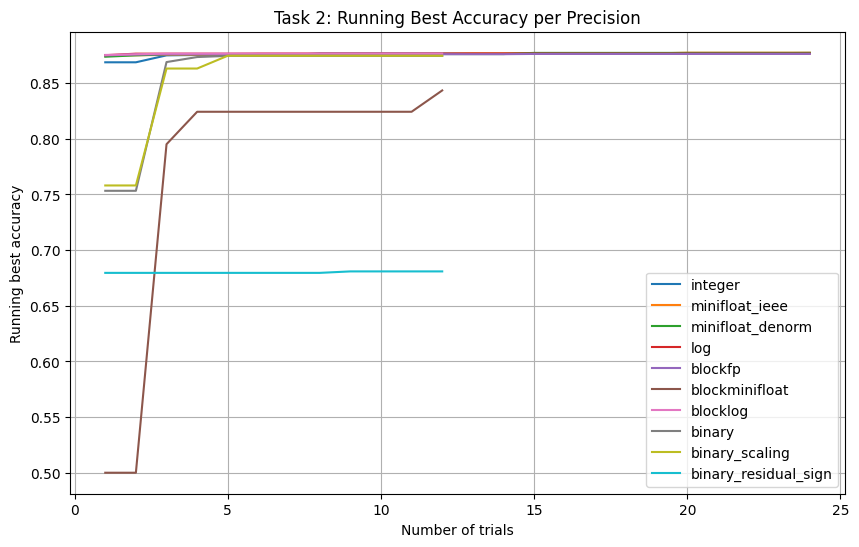

`past_key_values` were not specified as input names, but model.config.use_cache = True. Setting model.config.use_cache = False.
INFO     Getting dummy input for prajjwal1/bert-tiny.


Saved: /workspace/labs/lab3/outputs/tutorial6_task2_all_precisions_running_best.png
Saved summary JSON: /workspace/labs/lab3/outputs/tutorial6_impl_tasks_summary.json

=== Optional: Compression on Task 1 best model ===


INFO     Getting dummy input for prajjwal1/bert-tiny.


tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]],


        [[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       

INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: classifier


tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]],


        [[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       

/workspace/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


`past_key_values` were not specified as input names, but model.config.use_cache = True. Setting model.config.use_cache = False.
INFO     Getting dummy input for prajjwal1/bert-tiny.


Compressed (no post-train) eval_accuracy: 0.5020


INFO     Getting dummy input for prajjwal1/bert-tiny.


tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]],


        [[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       

INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: classifier


tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]],


        [[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       

/workspace/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.339200
1000,0.288100
1500,0.286100
2000,0.287200
2500,0.272400
3000,0.314200


Compressed (+ post-train 1 epoch) eval_accuracy: 0.8601

Done.


In [1]:
import gc
import json
from copy import deepcopy
from pathlib import Path

import optuna
import matplotlib.pyplot as plt
import torch
from torch import nn
from transformers import AutoModelForSequenceClassification

from chop.tools import get_tokenized_dataset, get_trainer
from chop.tools.utils import deepsetattr
import chop.passes as passes
from chop import MaseGraph
from chop.pipelines import CompressionPipeline

from chop.nn.quantized.modules.linear import (
    LinearInteger,
    LinearMinifloatDenorm,
    LinearMinifloatIEEE,
    LinearLog,
    LinearBlockFP,
    LinearBlockMinifloat,
    LinearBlockLog,
    LinearBinary,
    LinearBinaryScaling,
    LinearBinaryResidualSign,
)

# -----------------------------
# User config
# -----------------------------
checkpoint = "prajjwal1/bert-tiny"
tokenizer_checkpoint = "bert-base-uncased"
dataset_name = "imdb"

lab3_out_dir = Path("/workspace/labs/lab3/outputs")
lab3_out_dir.mkdir(parents=True, exist_ok=True)

lab2_out_dir = Path("/workspace/labs/lab2/outputs")

TOTAL_TRIALS = 12           # cap TOTAL COMPLETE trials per study
search_epochs = 1

pruning_sparsity = 0.5
post_compress_epochs = 1

HF_INPUT_NAMES = ["input_ids", "attention_mask", "labels"]
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# -----------------------------
# Optuna persistence (IMPORTANT)
# -----------------------------
OPTUNA_DB = lab3_out_dir / "optuna_tutorial6.db"
OPTUNA_STORAGE = f"sqlite:///{OPTUNA_DB.as_posix()}"

# -----------------------------
# Helpers
# -----------------------------
def cleanup(*objs):
    for o in objs:
        try:
            del o
        except Exception:
            pass
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()


def running_best(study: optuna.Study):
    best = float("-inf")
    xs, ys = [], []
    for t in sorted(study.trials, key=lambda x: x.number):
        if t.value is None:
            continue
        best = max(best, float(t.value))
        xs.append(len(xs) + 1)
        ys.append(best)
    return xs, ys


def json_safe(obj):
    if isinstance(obj, type):
        return f"{obj.__module__}.{obj.__qualname__}"
    if isinstance(obj, dict):
        return {k: json_safe(v) for k, v in obj.items()}
    if isinstance(obj, (list, tuple)):
        return [json_safe(v) for v in obj]
    return obj


def copy_linear_params(src: nn.Linear, dst: nn.Module):
    """Copy weights/bias if tensor shapes match."""
    with torch.no_grad():
        try:
            if hasattr(dst, "weight") and hasattr(src, "weight"):
                if getattr(dst.weight, "shape", None) == src.weight.shape:
                    dst.weight.copy_(src.weight)
        except Exception:
            pass
        try:
            if getattr(src, "bias", None) is not None and hasattr(dst, "bias"):
                if getattr(dst.bias, "shape", None) == src.bias.shape:
                    dst.bias.copy_(src.bias)
        except Exception:
            pass


def safe_best(study: optuna.Study):
    trials = study.get_trials(deepcopy=False)
    complete = [
        t for t in trials
        if t.state == optuna.trial.TrialState.COMPLETE and t.value is not None
    ]
    if not complete:
        return None, None
    best_t = max(complete, key=lambda t: float(t.value))
    return float(best_t.value), json_safe(best_t.params)


def n_complete(study: optuna.Study) -> int:
    trials = study.get_trials(deepcopy=False)
    return sum(t.state == optuna.trial.TrialState.COMPLETE for t in trials)


def save_study_snapshot(study: optuna.Study, out_path: Path):
    trials = study.get_trials(deepcopy=False)

    complete = [
        t for t in trials
        if t.state == optuna.trial.TrialState.COMPLETE and t.value is not None
    ]
    if complete:
        best_t = max(complete, key=lambda t: float(t.value))
        best_value = float(best_t.value)
        best_params = json_safe(best_t.params)
        best_number = best_t.number
    else:
        best_value = None
        best_params = None
        best_number = None

    snap = {
        "study_name": study.study_name,
        "storage": OPTUNA_STORAGE,
        "best_value": best_value,
        "best_trial_number": best_number,
        "best_params": best_params,
        "n_trials": len(trials),
        "n_complete": sum(t.state == optuna.trial.TrialState.COMPLETE for t in trials),
        "n_fail": sum(t.state == optuna.trial.TrialState.FAIL for t in trials),
        "n_pruned": sum(t.state == optuna.trial.TrialState.PRUNED for t in trials),
    }
    out_path.write_text(json.dumps(snap, indent=2))


def make_snapshot_callback(out_path: Path):
    def _cb(study: optuna.Study, trial: optuna.Trial):
        save_study_snapshot(study, out_path)
    return _cb


def optimize_to_total_complete(
    study: optuna.Study,
    objective,
    total_complete_target: int,
    **optimize_kwargs,
):
    remaining = max(0, total_complete_target - n_complete(study))
    if remaining == 0:
        print(f"[skip] {study.study_name}: already has {n_complete(study)} COMPLETE trials")
        return
    print(f"[run]  {study.study_name}: running {remaining} more trial(s) to reach {total_complete_target} COMPLETE")
    study.optimize(objective, n_trials=remaining, **optimize_kwargs)


# -----------------------------
# Dataset / tokenizer
# -----------------------------
dataset, tokenizer = get_tokenized_dataset(
    dataset=dataset_name,
    checkpoint=tokenizer_checkpoint,
    return_tokenizer=True,
)

# -----------------------------
# Base model loading
# -----------------------------
base_model_path = lab2_out_dir / "tutorial_5_best_model.pkl"
if base_model_path.exists():
    import dill
    with open(base_model_path, "rb") as f:
        base_model = dill.load(f)
else:
    base_model = AutoModelForSequenceClassification.from_pretrained(
        checkpoint, num_labels=2
    )

try:
    base_model.config.problem_type = "single_label_classification"
except Exception:
    pass

# -----------------------------
# Precision configs
# -----------------------------
INT_WIDTH_CHOICES = [8, 16, 32]
INT_FRAC_CHOICES = [2, 4, 8]


def make_integer_config_for_layer(trial: optuna.Trial, layer_name: str):
    din_w = trial.suggest_categorical(f"{layer_name}.data_in_width", INT_WIDTH_CHOICES)
    din_fw = trial.suggest_categorical(f"{layer_name}.data_in_frac_width", INT_FRAC_CHOICES)
    w_w = trial.suggest_categorical(f"{layer_name}.weight_width", INT_WIDTH_CHOICES)
    w_fw = trial.suggest_categorical(f"{layer_name}.weight_frac_width", INT_FRAC_CHOICES)
    b_w = trial.suggest_categorical(f"{layer_name}.bias_width", INT_WIDTH_CHOICES)
    b_fw = trial.suggest_categorical(f"{layer_name}.bias_frac_width", INT_FRAC_CHOICES)
    return {
        "data_in_width": din_w,
        "data_in_frac_width": din_fw,
        "weight_width": w_w,
        "weight_frac_width": w_fw,
        "bias_width": b_w,
        "bias_frac_width": b_fw,
        "bypass": False,
    }


def make_minifloat_config():
    return {
        "data_in_width": 8,
        "data_in_exponent_width": 5,
        "data_in_exponent_bias": 15,
        "weight_width": 8,
        "weight_exponent_width": 5,
        "weight_exponent_bias": 15,
        "bias_width": 8,
        "bias_exponent_width": 5,
        "bias_exponent_bias": 15,
        "bypass": False,
    }


def make_log_config():
    # for LinearLog (NOT blocklog)
    return {
        "data_in_width": 8,
        "data_in_exponent_bias": 15,
        "weight_width": 8,
        "weight_exponent_bias": 15,
        "bias_width": 8,
        "bias_exponent_bias": 15,
        "bypass": False,
    }


def make_blockfp_config(block_size: int = 32):
    # block_fp_quantizer accepts list[int]; keep consistent.
    return {
        "data_in_width": 12,
        "data_in_exponent_width": 8,
        "data_in_exponent_bias": None,
        "data_in_block_size": [int(block_size)],
        "data_in_skip_first_dim": True,

        "weight_width": 12,
        "weight_exponent_width": 8,
        "weight_exponent_bias": None,
        "weight_block_size": [int(block_size)],

        "bias_width": 12,
        "bias_exponent_width": 8,
        "bias_exponent_bias": None,
        "bias_block_size": [int(block_size)],

        "bypass": False,
    }


def make_blockminifloat_config(block_size: int = 32):
    # block_minifloat quantizer expects *_block_size to be a sequence (list is safest)
    return {
        "data_in_width": 8,
        "data_in_exponent_width": 5,
        "data_in_exponent_bias_width": 4,
        "data_in_block_size": [int(block_size)],
        "data_in_skip_first_dim": True,

        "weight_width": 8,
        "weight_exponent_width": 5,
        "weight_exponent_bias_width": 4,
        "weight_block_size": [int(block_size)],

        "bias_width": 8,
        "bias_exponent_width": 5,
        "bias_exponent_bias_width": 4,
        "bias_block_size": [int(block_size)],

        "bypass": False,
    }


def make_blocklog_config(block_size: int = 32, exponent_bias_width: int = 4):
    # required by linearBlockLog: *_exponent_bias_width and *_block_size
    return {
        "data_in_width": 8,
        "data_in_exponent_bias_width": int(exponent_bias_width),
        "data_in_block_size": [int(block_size)],
        "data_in_skip_first_dim": True,

        "weight_width": 8,
        "weight_exponent_bias_width": int(exponent_bias_width),
        "weight_block_size": [int(block_size)],

        "bias_width": 8,
        "bias_exponent_bias_width": int(exponent_bias_width),
        "bias_block_size": [int(block_size)],

        "bypass": False,
    }


def make_binary_common_config(levels: int = 2):
    return {
        "data_in_levels": int(levels),
        "weight_levels": int(levels),
        "bias_levels": int(levels),
        "data_in_stochastic": False,
        "weight_stochastic": False,
        "bias_stochastic": False,
        "data_in_bipolar": True,
        "weight_bipolar": True,
        "bias_bipolar": True,
        "binary_training": True,
        "data_in_residual_sign": True,
        "bypass": False,
    }


def config_for_precision(prec_name: str, trial: optuna.Trial | None, layer_name: str):
    if prec_name == "integer":
        assert trial is not None
        return make_integer_config_for_layer(trial, layer_name)

    if prec_name in ("minifloat_ieee", "minifloat_denorm"):
        return make_minifloat_config()

    if prec_name == "log":
        return make_log_config()

    if prec_name == "blockfp":
        return make_blockfp_config(block_size=32)

    if prec_name == "blockminifloat":
        return make_blockminifloat_config(block_size=32)

    if prec_name == "blocklog":
        return make_blocklog_config(block_size=32, exponent_bias_width=4)

    if prec_name in ("binary", "binary_scaling", "binary_residual_sign"):
        return make_binary_common_config(levels=2)

    return {
        "data_in_width": 8,
        "weight_width": 8,
        "bias_width": 8,
        "bypass": False,
    }


# -----------------------------
# Precision families
# -----------------------------
PRECISIONS = [
    ("integer", LinearInteger),
    ("minifloat_ieee", LinearMinifloatIEEE),
    ("minifloat_denorm", LinearMinifloatDenorm),
    ("log", LinearLog),
    ("blockfp", LinearBlockFP),
    ("blockminifloat", LinearBlockMinifloat),
    ("blocklog", LinearBlockLog),
    ("binary", LinearBinary),
    ("binary_scaling", LinearBinaryScaling),
    ("binary_residual_sign", LinearBinaryResidualSign),
]
PREC_BY_NAME = {n: c for n, c in PRECISIONS}


def construct_model_for_precision(trial: optuna.Trial, prec_name: str):
    prec_cls = PREC_BY_NAME[prec_name]
    trial_model = deepcopy(base_model)

    for name, layer in trial_model.named_modules():
        if not isinstance(layer, nn.Linear):
            continue

        choice = trial.suggest_categorical(f"{name}_type", ("fp", prec_name))
        if choice == "fp":
            continue

        cfg = config_for_precision(prec_name, trial, name)
        kwargs = {
            "in_features": layer.in_features,
            "out_features": layer.out_features,
            "bias": (layer.bias is not None),
            "config": cfg,
        }

        new_layer = prec_cls(**kwargs)
        copy_linear_params(layer, new_layer)
        deepsetattr(trial_model, name, new_layer)

    try:
        trial_model.config.problem_type = "single_label_classification"
    except Exception:
        pass

    return trial_model


# Some precisions fail in backward (or are meant as forward-only). We evaluate only.
EVAL_ONLY_PRECS = {"blockminifloat", "binary_residual_sign"}


def make_objective_for_precision(prec_name: str):
    def objective(trial: optuna.Trial):
        trainer = None
        model = None
        try:
            model = construct_model_for_precision(trial, prec_name).to(device)
            trainer = get_trainer(
                model=model,
                tokenized_dataset=dataset,
                tokenizer=tokenizer,
                evaluate_metric="accuracy",
                num_train_epochs=(0 if prec_name in EVAL_ONLY_PRECS else search_epochs),
            )
            if prec_name not in EVAL_ONLY_PRECS:
                trainer.train()
            ev = trainer.evaluate()
            return float(ev["eval_accuracy"])
        finally:
            cleanup(trainer, model)
    return objective


# -----------------------------
# Task 1: Integer search (CAP at 12 COMPLETE, otherwise skip)
# -----------------------------
print("=== Task 1: Integer per-layer width/frac search ===")
sampler = optuna.samplers.TPESampler(seed=0)
study_int = optuna.create_study(
    direction="maximize",
    sampler=sampler,
    study_name="tutorial6_integer_layerwise_widthfrac",
    storage=OPTUNA_STORAGE,
    load_if_exists=True,
)

optimize_to_total_complete(
    study_int,
    make_objective_for_precision("integer"),
    total_complete_target=TOTAL_TRIALS,
    callbacks=[make_snapshot_callback(lab3_out_dir / "task1_integer_snapshot.json")],
    catch=(Exception,),
)

x1, y1 = running_best(study_int)
plt.figure(figsize=(8, 5))
plt.plot(x1, y1, marker="o")
plt.xlabel("Number of trials")
plt.ylabel("Running best accuracy")
plt.title("Task 1: Integer layer-wise widths (Running Best)")
plt.grid(True)
task1_plot = lab3_out_dir / "tutorial6_task1_integer_layerwise_running_best.png"
plt.savefig(task1_plot)
plt.show()

bv, bp = safe_best(study_int)
print("Task 1 best:", bv)
print("Saved:", task1_plot)


# -----------------------------
# Task 2: Compare precision families (CAP each at 12 COMPLETE, otherwise skip)
# -----------------------------
print("\n=== Task 2: Compare precision families ===")
studies = {}

for prec_name, _ in PRECISIONS:
    print(f"\n-- Running study for precision: {prec_name}")
    sampler = optuna.samplers.TPESampler(seed=0)
    st = optuna.create_study(
        direction="maximize",
        sampler=sampler,
        study_name=f"tutorial6_prec_{prec_name}",
        storage=OPTUNA_STORAGE,
        load_if_exists=True,
    )

    snap_path = lab3_out_dir / f"task2_{prec_name}_snapshot.json"

    optimize_to_total_complete(
        st,
        make_objective_for_precision(prec_name),
        total_complete_target=TOTAL_TRIALS,
        catch=(Exception,),
        callbacks=[make_snapshot_callback(snap_path)],
    )

    studies[prec_name] = st

    bv2, _ = safe_best(st)
    if bv2 is not None:
        print(f"Best for {prec_name}: {bv2:.4f}")
    else:
        print(f"Best for {prec_name}: None (no COMPLETE trials)")
    print("Snapshot:", snap_path)

plt.figure(figsize=(10, 6))
for prec_name, st in studies.items():
    xs, ys = running_best(st)
    if xs:
        plt.plot(xs, ys, label=prec_name)
plt.xlabel("Number of trials")
plt.ylabel("Running best accuracy")
plt.title("Task 2: Running Best Accuracy per Precision")
plt.grid(True)
plt.legend()
task2_plot = lab3_out_dir / "tutorial6_task2_all_precisions_running_best.png"
plt.savefig(task2_plot)
plt.show()

print("Saved:", task2_plot)

summary = {
    "optuna_storage": OPTUNA_STORAGE,
    "task1_integer_layerwise": {
        "best_value": (bv),
        "best_params": (bp),
        "n_trials_total": len(study_int.trials),
        "n_complete": n_complete(study_int),
        "search_epochs": search_epochs,
        "sampler": "TPESampler",
        "plot": str(task1_plot),
    },
    "task2_all_precisions": {
        "target_complete_each": TOTAL_TRIALS,
        "search_epochs": search_epochs,
        "sampler": "TPESampler",
        "plot": str(task2_plot),
        "best_by_precision": {
            name: {
                "best_value": safe_best(st)[0],
                "best_params": safe_best(st)[1],
                "n_trials_total": len(st.trials),
                "n_complete": n_complete(st),
            }
            for name, st in studies.items()
        },
    },
}

summary_path = lab3_out_dir / "tutorial6_impl_tasks_summary.json"
summary_path.write_text(json.dumps(summary, indent=2))
print("Saved summary JSON:", summary_path)


# -----------------------------
# Optional: Compression pass
# -----------------------------
BASE_QUANTIZATION_CONFIG = {
    "by": "type",
    "default": {"config": {"name": None}},
    "linear": {
        "config": {
            "name": "integer",
            "data_in_width": 8,
            "data_in_frac_width": 4,
            "weight_width": 8,
            "weight_frac_width": 4,
            "bias_width": 8,
            "bias_frac_width": 4,
        }
    },
}
BASE_PRUNING_CONFIG = {
    "weight": {"sparsity": pruning_sparsity, "method": "l1-norm", "scope": "local"},
    "activation": {"sparsity": pruning_sparsity, "method": "l1-norm", "scope": "local"},
}


def compress_with_mase(model_cpu: nn.Module):
    mg = MaseGraph(model_cpu, hf_input_names=HF_INPUT_NAMES)
    mg, _ = passes.init_metadata_analysis_pass(mg)
    mg, _ = passes.add_common_metadata_analysis_pass(mg)

    qcfg = deepcopy(BASE_QUANTIZATION_CONFIG)
    pcfg = deepcopy(BASE_PRUNING_CONFIG)

    pipe = CompressionPipeline()
    mg, _ = pipe(
        mg,
        pass_args={
            "quantize_transform_pass": qcfg,
            "prune_transform_pass": pcfg,
        },
    )
    return mg


print("\n=== Optional: Compression on Task 1 best model ===")
if bp is None:
    print("Skipping compression: Task 1 has no COMPLETE trials / no best params.")
else:
    fixed_trial = optuna.trial.FixedTrial(bp)
    best_model_task1 = construct_model_for_precision(fixed_trial, "integer")

    mg_a = None
    trainer_a = None
    try:
        mg_a = compress_with_mase(deepcopy(best_model_task1).to("cpu"))
        model_a = mg_a.model.to(device)
        trainer_a = get_trainer(
            model=model_a,
            tokenized_dataset=dataset,
            tokenizer=tokenizer,
            evaluate_metric="accuracy",
            num_train_epochs=0,
        )
        ev_a = trainer_a.evaluate()
        acc_a = float(ev_a["eval_accuracy"])
        print(f"Compressed (no post-train) eval_accuracy: {acc_a:.4f}")
    finally:
        cleanup(trainer_a, mg_a)

    mg_b = None
    trainer_b = None
    try:
        mg_b = compress_with_mase(deepcopy(best_model_task1).to("cpu"))
        model_b = mg_b.model.to(device)
        trainer_b = get_trainer(
            model=model_b,
            tokenized_dataset=dataset,
            tokenizer=tokenizer,
            evaluate_metric="accuracy",
            num_train_epochs=post_compress_epochs,
        )
        trainer_b.train()
        ev_b = trainer_b.evaluate()
        acc_b = float(ev_b["eval_accuracy"])
        print(f"Compressed (+ post-train {post_compress_epochs} epoch) eval_accuracy: {acc_b:.4f}")
    finally:
        cleanup(trainer_b, mg_b)

print("\nDone.")
